# Cell enrichments

Goal: Do cell type enrichment analysis

In [1]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [9]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from enrichments import *
from gradientVersion import *
%R source("../code/enrichmentsPlots.R");

Get cell genes from jakob's data

In [3]:
cell_genes = get_cell_genes()
# brain_genes = pd.read_csv("../data/jakob_brain_genes.csv", squeeze=True)

Get gradients

In [320]:
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')
dm_hcp_3d_ds5.fit_weights()

New gradients version: method=dm, kernel=normalized_angle, data=hcp_3donors_ds5


,0,1,2,3,4
A1BG,-1.325553,-0.524968,0.085946,1.254390,0.496824
A1BG-AS1,-1.015308,-0.191664,-1.422092,0.412428,0.840518
AAAS,1.094565,0.358321,0.268885,1.669238,1.288715
AAED1,-1.181391,-0.116840,0.766876,-0.118689,0.655870
AAGAB,-0.399618,1.698619,-1.294172,0.479090,-0.996766
...,...,...,...,...,...
ZSWIM9,-0.837269,-0.040461,0.247378,-2.120443,1.589688
ZWINT,-1.056249,-0.829489,0.074836,0.062994,0.418127
ZYX,1.577823,0.450030,-0.309959,0.520665,-0.150477
ZZEF1,1.219275,-1.242534,0.890130,-0.386196,1.175977


In [321]:
version = dm_hcp_3d_ds5
weights = version.weights.iloc[:,:3]
nulls = shuffle_gene_weights(weights, n=10000, rank=False)

Make mask of cell genes retained in PCs

In [324]:
gene_masks = match_cell_genes(cell_genes, weights)

Compute scores and p-values against random nulls, either with mean score, or median rank (how == 'median')

In [389]:
true_scores, null_scores = compute_cell_scores(
    weights, nulls, gene_masks, how='mean')

null_p = compute_null_p(true_scores, null_scores, adjust='fdr_bh')

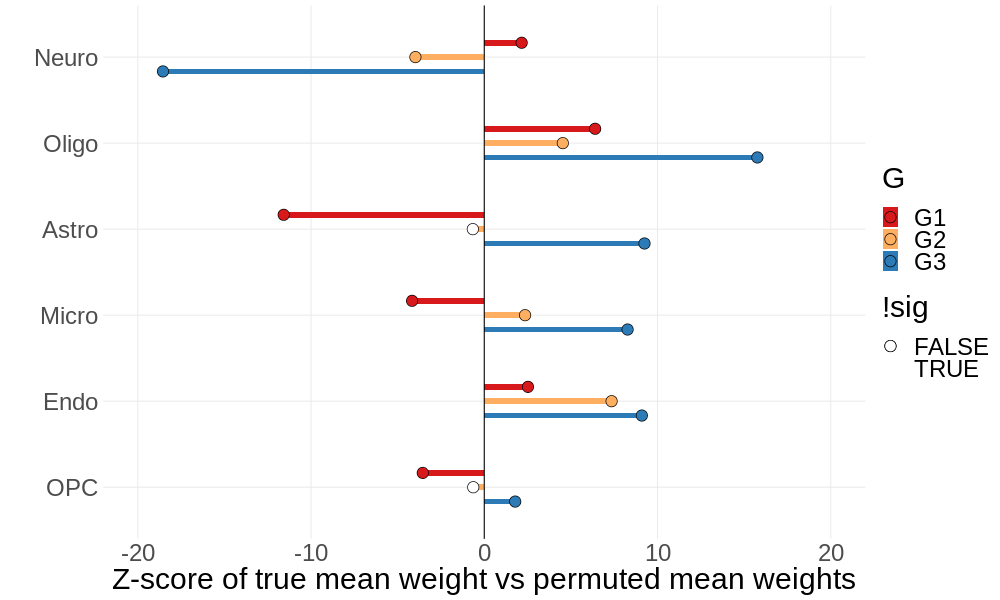

In [466]:
%%R -i null_p -w 1000 -h 600
source("../code/enrichmentsPlots.R")
plot_cell_dotplot(null_p)

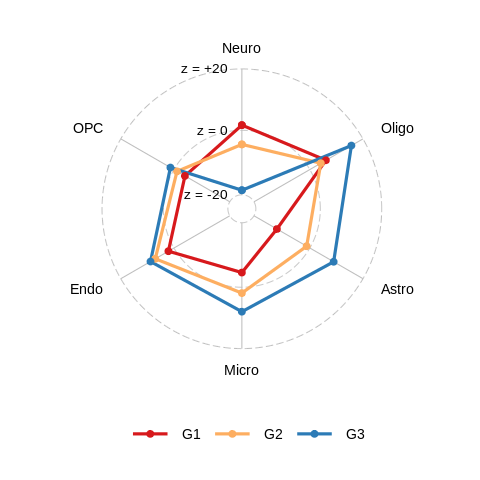

In [465]:
%%R -i null_p
source("../code/enrichmentsPlots.R")
plot_cell_radar(null_p)

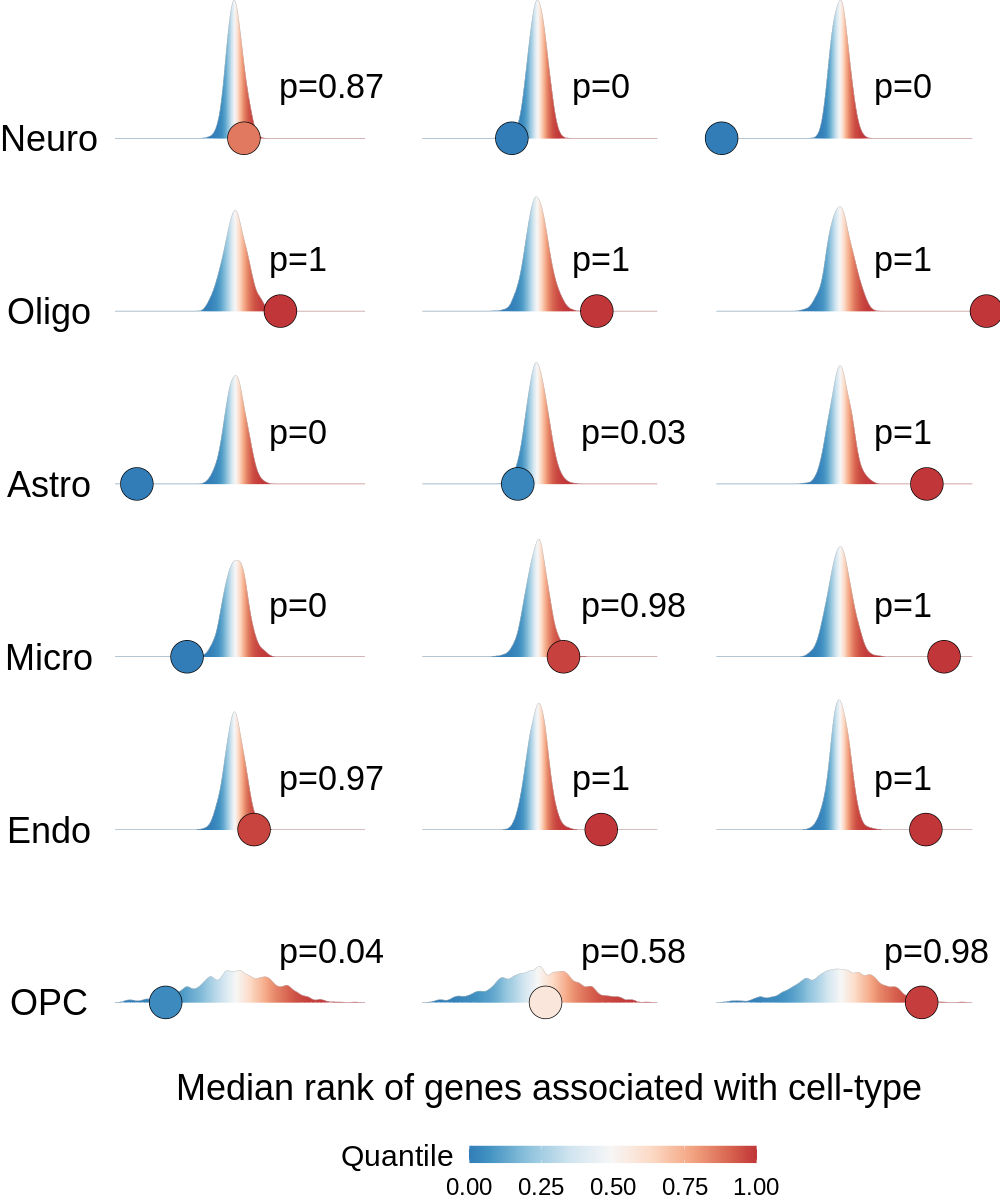

In [125]:
%%R -i true_scores -i null_scores -i null_p -w 1000 -h 1200
source("../code/enrichmentsPlots.R")
plot_cell_enrichment(true_scores, null_scores, null_p, how='median')

---

# Legacy

In [152]:
data_dir = "~/rds/rds-cam-psych-transc-Pb9UGUlrwWc/Cam_LIBD/AHBA_data/abagen-data/expression/"
# hcp_base = pcaVersion(pd.read_csv(data_dir + 'hcp_base.csv', index_col=0))
# hcp_3donors_ds75 = pcaVersion(get_expression_abagen(atlas=fetch_hcp(native=True), donors_threshold=3, DS_threshold=0.75, save_name='hcp_3donors_ds75'))
# hcp_3donors_ds8 = pcaVersion(get_expression_abagen(atlas=fetch_hcp(native=True), donors_threshold=3, DS_threshold=0.8, save_name='hcp_3donors_ds8'))
# hcp_3donors_ds75 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds75.csv', index_col=0))
# hcp_3donors_ds8 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds8.csv', index_col=0))
hcp_3donors_ds5 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds5.csv', index_col=0))
# pc_version = hcp_3donors_ds8

New PCA version


In [100]:
# dk_ds5 = pcaVersion(pd.read_csv(data_dir + 'dk_ds5.csv', index_col=0))
# dk_3donors_ds8 = pcaVersion(pd.read_csv(data_dir + 'dk_3donors_ds8.csv', index_col=0))
# dk_ds7 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), DS_threshold=0.7, save_name='dk_ds7'))
# dk_ds8 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), DS_threshold=0.8, save_name='dk_ds8'))
# dk_ds7 = pcaVersion(pd.read_csv(data_dir + 'dk_ds7.csv', index_col=0))

3190 genes remain after filtering for top 0.2 differential stability
New PCA version


Shuffle gene weights to make random nulls

In [188]:
weights = pc_version.coefs.iloc[:3,:].T
nulls = shuffle_gene_weights(weights, n=10000)

Make mask of cell genes retained in PCs

In [199]:
gene_masks = match_cell_genes(cell_genes, pc_version)

Compute scores and p-values against random nulls, either with mean score, or median rank (how == 'median')

In [202]:
true_scores, null_scores = compute_cell_scores(
    weights, nulls, gene_masks, how='median')

order = ['Neuro', 'Oligo', 'Astro', 'Micro', 'Endo', 'OPC']
null_p = compute_null_p(true_scores, null_scores, signed=False).loc[order]

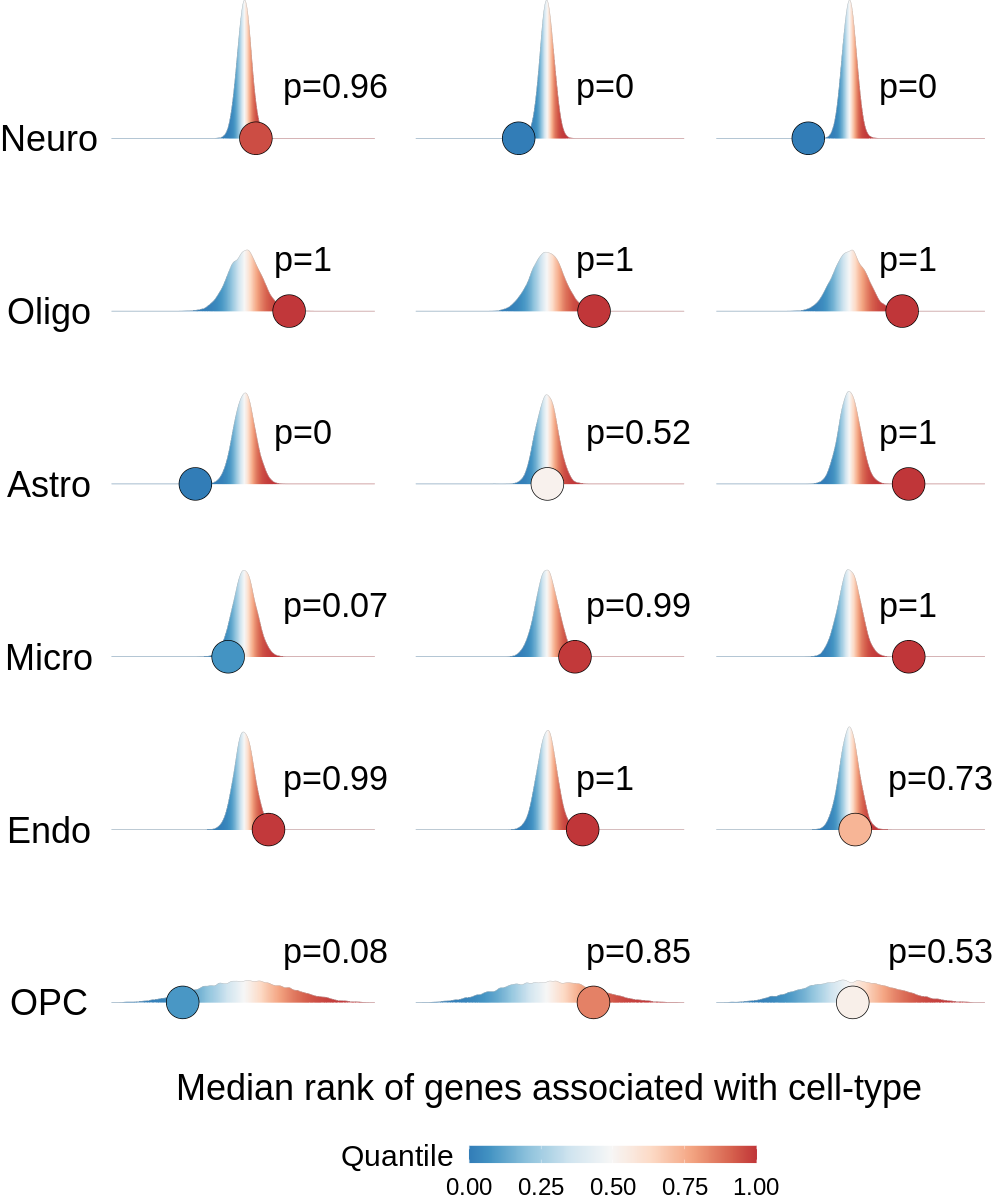

In [203]:
%%R -i true_scores -i null_scores -i null_p -w 1000 -h 1200
source("../code/enrichmentsPlots.R")
plot_cell_enrichment(true_scores, null_scores, null_p, how='median')

---

## Cell type DS

In [5]:
stability = pd.read_csv("../outputs/stability.csv", index_col=0).set_axis(['DS'], axis=1)

In [33]:
order = ['Neuro', 'Oligo', 'Astro', 'Micro', 'Endo', 'OPC']

cell_genes_DS = (cell_genes
 .join(stability, on='Gene')
 .assign(DS_pct = lambda x: x['DS'].rank(pct=True))
 .assign(DS8 = lambda x: x['DS_pct'] > 0.8)
 .assign(Class = lambda x: pd.Categorical(x['Class'], categories=order, ordered=True))
)
cell_genes_DS

,Class,Gene,DS,DS_pct,DS8
543,Astro,A2ML1,-0.027507,0.004966,False
15668,Astro,AADAT,0.038855,0.101150,False
6255,Astro,AASS,0.115757,0.355724,False
16172,Astro,ABCA12,NaN,NaN,False
6983,Astro,ABCA7,0.131257,0.411396,False
...,...,...,...,...,...
6292,Oligo,ZNHIT6,0.096713,0.286722,False
8476,Oligo,ZSCAN12P1,NaN,NaN,False
12307,Oligo,ZSCAN29,0.301061,0.775222,False
5055,Oligo,ZSWIM5P2,NaN,NaN,False


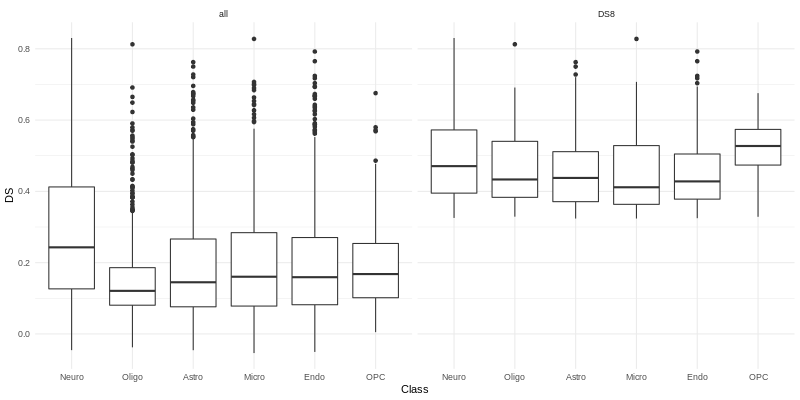

In [37]:
%%R -i cell_genes_DS -w 800 -h 400
library(tidyverse)
c1 <- cell_genes_DS %>% mutate(group = 'all')
c2 <- cell_genes_DS %>% mutate(group = 'DS8') %>% filter(DS8)
rbind(c1, c2) %>%
ggplot() + facet_wrap(~group) +
geom_boxplot(aes(x=Class, y=DS)) +
theme_minimal()

In [ ]:
brain_genes = pd.read_csv("../data/jakob_brain_genes.csv", squeeze=True)

---

In [82]:
order = ['Neuro', 'Oligo', 'Astro', 'Micro', 'Endo', 'OPC']
null_pcts = compute_null_p(true_scores, null_scores, signed=False).loc[order]
null_pcts

,PC1,PC2,PC3
Neuro,0.99880,0.00000,0.00000
Oligo,0.99430,0.99900,0.99980
Astro,0.00000,0.45435,1.00000
Micro,0.06445,0.99670,1.00000
Endo,0.99450,1.00000,0.69945
OPC,0.21550,0.14180,0.33670


In [ ]:
%%R -i null_pcts -i null_scores

p_sig <- .05/7

null_pcts %>%
rownames_to_column('c') %>%
gather(pc, pct, -c) %>%
mutate(sig = ifelse(pct < p_sig | pct > 1-p_sig, T, F)) %>%
mutate(c = factor(c, levels=.$c %>% unique)) %>%
ggplot() + 
geom_tile(aes(x=pc, y=c, fill=pct, alpha=sig)) +
geom_text(aes(x=pc, y=c, label=pct)) +
scale_y_discrete(limits=rev) +
scale_fill_gradientn(colors=rev(brewer.rdbu(100)[15:85]),
                    name = 'Quantile') +
scale_alpha_manual(values=c(.2,1), guide='none') +
scale_x_discrete(position = "top") +
xlab('') + ylab('') +
theme_minimal() + 
theme(panel.grid=element_blank())

In [162]:
# cell_genes = get_cell_genes()
cell_genes = pd.DataFrame({
    'Gene': ['ADNP', 'ANK2', 'ANKRD11', 'ARID1B', 'ASH1L', 'ASXL3', 'AUTS2', 'CASK', 'CDKL5', 'CHAMP1', 'CHD2', 'CHD7', 'CHD8', 'CTNNB1', 'DMD', 'DPP6', 'DPYD', 'DSCAM', 'DYRK1A', 'EFTUD2', 'EHMT1', 'EP300', 'FOXP1', 'GRIN2B', 'IL1RAPL1', 'IQSEC2', 'KANSL1', 'KCNQ2', 'KDM5B', 'KDM6A', 'KMT2A', 'MAGEL2', 'MBD5', 'MECP2', 'MED13L', 'MEF2C', 'MYT1L', 'NRXN1', 'NSD1', 'POGZ', 'PTCHD1', 'PTEN', 'PURA', 'RAI1', 'SCN1A', 'SCN2A', 'SETBP1', 'SETD1A', 'SETD5', 'SHANK3', 'SLC2A1', 'SLC35A2', 'SRCAP', 'STXBP1', 'SYNGAP1', 'TCF4', 'UBE3A', 'WDR45', 'ZMYND11']
}).assign(Class = 'dev candidates')

In [164]:
gene_masks = match_cell_genes(cell_genes, pc_version)
true_scores, null_scores = compute_cell_scores(
    weights, null_weights, gene_masks, how='mean')

null_p = compute_null_p(true_scores, null_scores, signed=False)

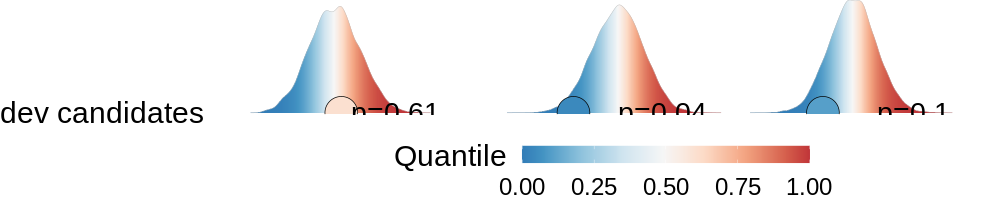

In [167]:
%%R -i true_scores -i null_scores -i null_p -w 1000 -h 200
source("../code/enrichmentsPlots.R")

plot_cell_enrichment(true_scores, null_scores, null_p) + xlab('')